In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import mplhep as hep
plt.style.use(hep.style.CMS)
#from plotting_utils import *
import uproot
import awkward as ak
#import dask.dataframe as dd
#from dask.distributed import Client

#client = Client(dashboard=True)

In [2]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/overlapping_objects_studies/electrons_genmatching"
#input_folder= "/work/dvalsecc/Clustering/dataset/overlapping_studies"
output_folder = "plots/electrons_gen_matching_v2"
os.makedirs(output_folder, exist_ok=True)
df = pd.HDFStore(f"{input_folder}/Mustache_126X_mcRun3_2023_v1.hdf5", "r")["df"]
df.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df = df.iloc[:-1]

#df = dd.from_pandas(df, npartitions=4)

In [3]:
df.elematched = df.deltaR_genPart_ele < 0.3

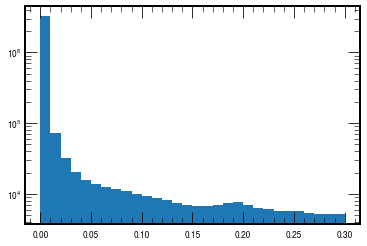

In [4]:
plt.hist(df[df.elematched].deltaR_genPart_ele, bins=30)
plt.yscale("log")

In [5]:
sum(df.elematched) / len(df)

0.8926563149601418

In [9]:
list(df.columns)

['genpart_index',
 'elematched',
 'phomatched',
 'ele_index',
 'pho_index',
 'deltaR_genPart_ele',
 'deltaR_genPart_pho',
 'calomatched',
 'caloindex',
 'sc_matched',
 'sc_index',
 'seed_index',
 'en_seed',
 'et_seed',
 'en_seed_calib',
 'et_seed_calib',
 'seed_eta',
 'seed_phi',
 'seed_iz',
 'sc_eta',
 'sc_phi',
 'sc_swissCross',
 'sc_r9',
 'sc_sigmaIetaIeta',
 'sc_sigmaIetaIphi',
 'sc_sigmaIphiIphi',
 'sc_e5x5',
 'sc_swissCross_f5x5',
 'sc_r9_f5x5',
 'sc_sigmaIetaIeta_f5x5',
 'sc_sigmaIetaIphi_f5x5',
 'sc_sigmaIphiIphi_f5x5',
 'sc_e5x5_f5x5',
 'ele_eta',
 'ele_phi',
 'ele_energy',
 'ele_et',
 'ele_ecalEnergy',
 'ele_ecalSCEnergy',
 'ele_scRawEnergy',
 'ele_scRawESEnergy',
 'ele_SCfbrem',
 'ele_tracfbrem',
 'ele_e5x5',
 'ele_e3x3',
 'ele_sigmaIEtaIEta',
 'ele_sigmaIEtaIPhi',
 'ele_sigmaIPhiIPhi',
 'ele_ecalIso03',
 'ele_trkIso03',
 'ele_hcalIso03',
 'ele_pfChargedHadronIso',
 'ele_pfNeutralHadronIso',
 'ele_pfPhotonIso',
 'ele_HoE',
 'ele_deltaEtaSeedClusterAtCalo',
 'ele_deltaPhiSeed

In [6]:
def calculate_deltaR(group):
    # Extract relevant columns
    group = group.sort_values(by='genpart_index')
    #print(group[['genpart_index','genpart_eta','genpart_phi']])
    eta = group['genpart_eta'].values
    phi = group['genpart_phi'].values
    et_gen = group['genpart_et'].values
    ele_et=group['ele_et'].values
    ele_index = group['ele_index'].values
    elematched = group['elematched'].values
    
    # Calculate differences and means
    eta_diff = eta[::2] - eta[1::2]
    dphi = (phi[::2] - phi[1::2])
    dphi[dphi > np.pi] -= 2 * np.pi
    dphi[dphi < -np.pi] += 2 * np.pi
    dr_diff = np.sqrt(eta_diff**2 + dphi**2)
    eta_mean = (eta[::2] + eta[1::2]) / 2
    phi_mean = (phi[::2] + phi[1::2]) / 2
    
    data = {
        'deltaR': dr_diff,
        'eta_mean': eta_mean,
        'phi_mean': phi_mean,
        "calo_energy1": et_gen[::2],
        'calo_energy2': et_gen[1::2],
        'ele_et1':ele_et[::2],
        'ele_et2':ele_et[1::2],
        'ele_index1': ele_index[::2],
        'ele_index2': ele_index[1::2],
        'ele_matched1': elematched[::2],
        'ele_matched2': elematched[1::2],
    }
    
    return pd.DataFrame(data)

grouped_deltas = df.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas.to_csv('grouped_deltas.csv', index=False)

In [7]:
grouped_deltas 

deltaR  eta_mean  phi_mean  calo_energy1  calo_energy2  \
runId   eventId                                                               
1.0     1.0     0  0.556688 -1.996164 -0.380098    154.856959    306.222165   
                1  0.320304 -0.050764  1.119241    224.221212    402.985241   
                2  0.375094  0.295347 -2.013023      5.700451    299.433254   
                3  0.335604  2.580305 -2.770359    398.068529    356.120304   
        2.0     0  0.119264 -1.800459  1.549486    435.421919    165.661100   
...                     ...       ...       ...           ...           ...   
10000.0 49.0    3  0.089079  2.324892  0.948665    233.337585    232.570326   
        50.0    0  0.653780 -2.461026  1.025318    202.269281    246.267450   
                1  0.166304 -1.330882 -2.856730    104.928954    119.131572   
                2  0.440140  0.856887 -0.171696     23.532720    134.001787   
                3  0.571429  2.118894  2.018532    138.248855    465.738321   

                      ele_et1     ele_et2  ele_index1  ele_index2  \
runId   eventId                                                     
1.0     1.0     0  155.941635  312.286835         6.0         3.0   
                1  222.614990  402.312714         5.0         0.0   
                2    5.629723  297.365082         7.0         4.0   
                3  370.928894  325.344574         1.0         2.0   
        2.0     0  437.367462  162.961273         1.0         7.0   
...                       ...         ...         ...         ...   
10000.0 49.0    3  272.388977  322.311523         4.0         3.0   
        50.0    0  204.974945  249.907928         2.0         1.0   
                1  105.216576  119.402885         6.0         5.0   
                2   24.010637  133.340271         7.0         4.0   
                3  134.986710  462.061523         3.0         0.0   

                   ele_matched1  ele_matched2  
runId   eventId                                
1.0     1.0     0          True          True  
                1          True          True  
                2          True          True  
                3          True          True  
        2.0     0          True          True  
...                         ...           ...  
10000.0 49.0    3          True          True  
        50.0    0          True          True  
                1          True          True  
                2          True          True  
                3          True          True  

[2000000 rows x 11 columns]

In [8]:
print(f"% of windows with genpart1 matched to electron: {sum(grouped_deltas.ele_matched1 == True)/ len(grouped_deltas)*100:.3f}%")
print(f"% of windows with genpart2 matched to electron: {sum(grouped_deltas.ele_matched2 == True)/ len(grouped_deltas)*100:.3f}%")

% of windows with genpart1 matched to electron: 89.361%
% of windows with genpart2 matched to electron: 89.172%


# Event same ele_index

In [2]:
grouped_deltas = pd.read_csv('grouped_deltas.csv')

In [3]:
same_ele_index_mask = grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']
same_ele_events = grouped_deltas[same_ele_index_mask]
print(same_ele_events)

           deltaR  eta_mean  phi_mean  calo_energy1  calo_energy2     ele_et1  \
8        0.396164 -2.731669  1.005955     74.392734     75.991481   74.828079   
11       0.121039  2.323035 -2.927818    167.584058     21.289917  281.004059   
14       0.408611  1.463442  0.081365    381.190756    447.693415  379.742859   
15       0.664554  2.216470 -0.587010    268.397434    159.325919  158.318863   
20       0.057895 -1.866780 -0.287161    488.966629    164.659506  506.989685   
...           ...       ...       ...           ...           ...         ...   
1999982  0.278933 -0.031356  0.063859    321.563010     58.471184   57.519592   
1999985  0.259072 -0.342276 -1.717838     50.851508     67.029474   67.504875   
1999987  0.007870  2.922063  0.379218    498.279930    122.384367  110.036560   
1999988  0.535124 -2.783971  1.412874    326.650980     42.936407  489.576569   
1999992  0.258128 -2.157015  2.394996    495.885165    358.306012  356.996521   

            ele_et2  ele_in

In [4]:
max_energy1 = (same_ele_events['calo_energy2']).max()
min_energy1 = same_ele_events['calo_energy2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 499.999859377693
Minimum energy1: 1.0002473914619543


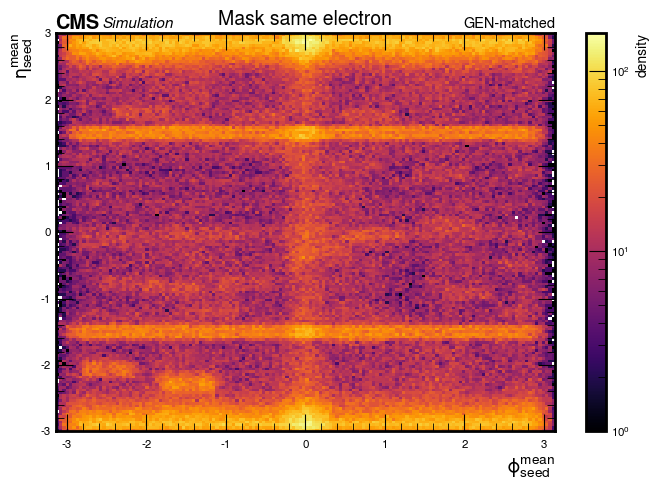

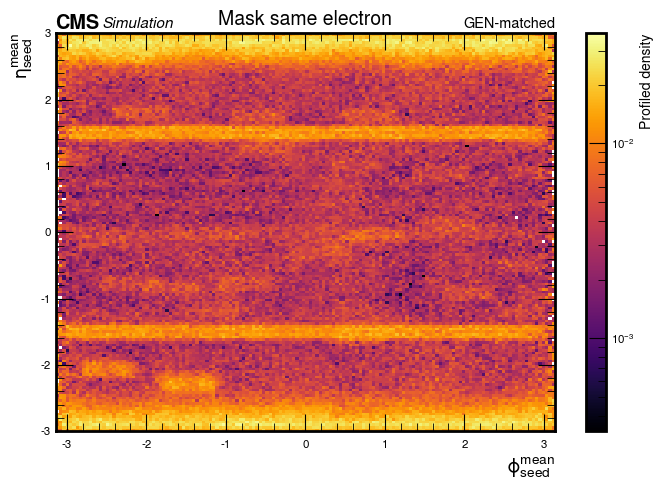

In [11]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi.png')
plt.show()
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Profiled density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
plt.savefig('plots/eta_phi_prof.png')


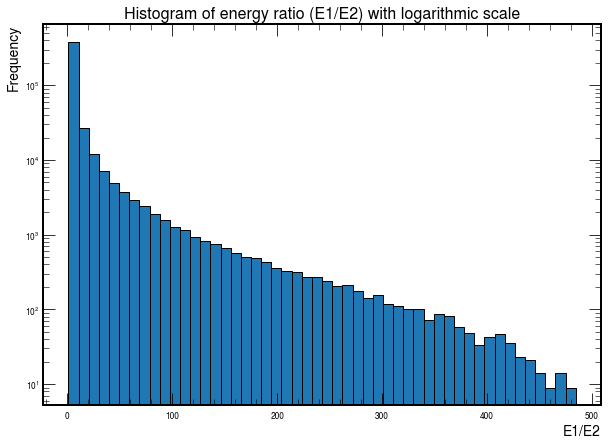

min energyratio:  1.0000001119237847


In [19]:
energy_ratio = same_ele_events['calo_energy1'] / same_ele_events['calo_energy2']
energy_ratio[same_ele_events['calo_energy1'] < same_ele_events['calo_energy2']] = same_ele_events['calo_energy2'] / same_ele_events['calo_energy1']

plt.subplots(figsize=(10,7))
plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('E1/E2', fontsize=14)  # Increase fontsize for x-label
plt.ylabel('Frequency', fontsize=14)  # Increase fontsize for y-label
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale', fontsize=16)  # Increase fontsize for title
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())

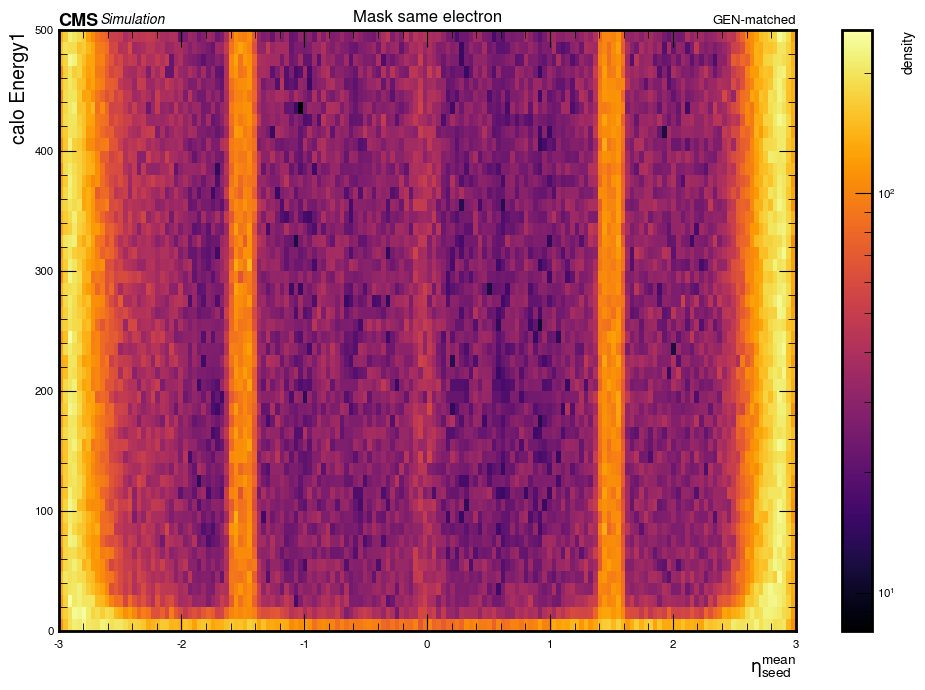

In [6]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy1,bins=(160, 50), range=((-3,3),(0,500)))

s = 1 #np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1_eta.png')

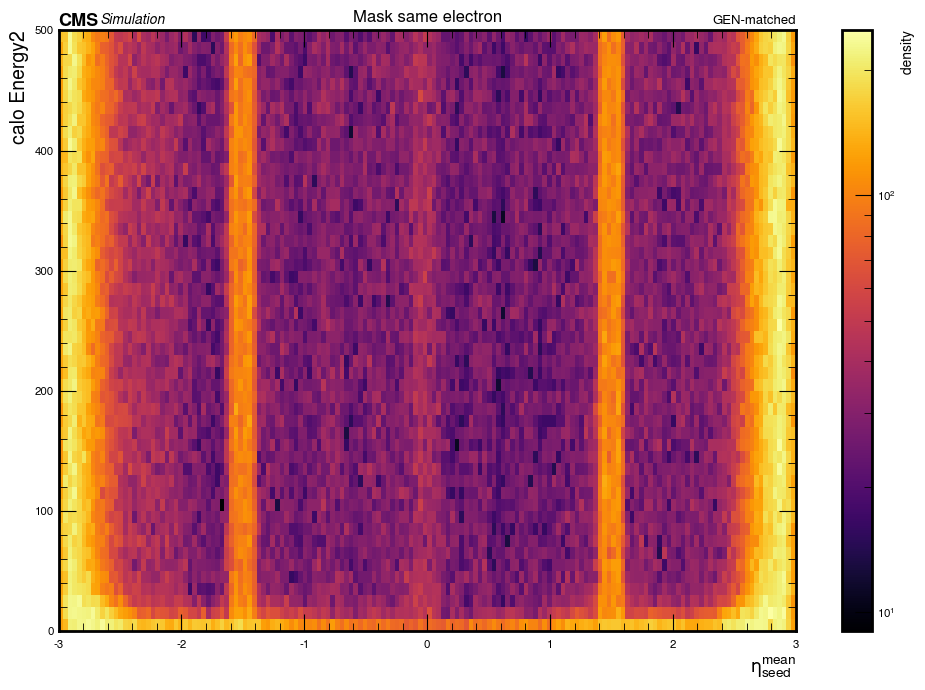

In [7]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy2,bins=(160, 50), range=((-3,3),(0,500)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label=" density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e2_eta.png')

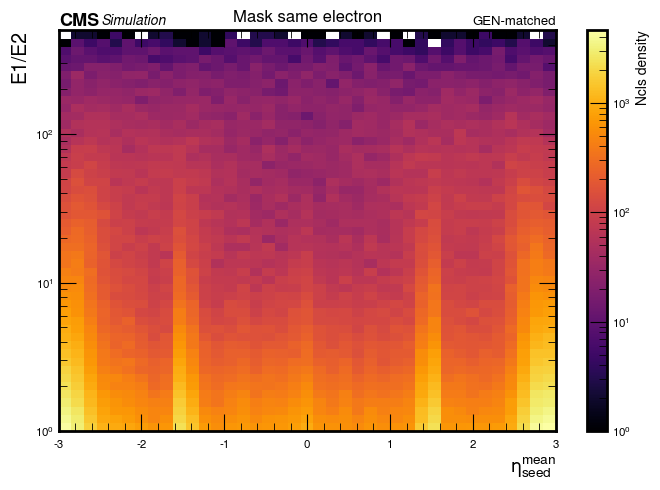

In [8]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio, 
                                  bins=[
                                      np.linspace(-3,3,40), np.logspace(0, np.log10(500), 50, base=10)
                                  ])

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("E1/E2", fontsize=14)
plt.title('Mask same electron')
ax.set_yscale("log")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/e1-e2_eta.png')

## ele_et

In [9]:
max_energy1 = (same_ele_events['ele_et1']).max()
min_energy1 = same_ele_events['ele_et2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 3098.338623046875
Minimum energy1: 0.0643110051751136


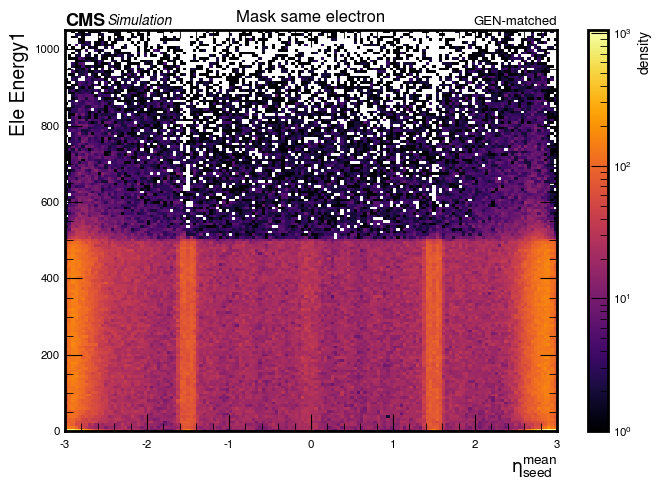

In [10]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.ele_et1,bins=(150, 150), range=((-3,3),(0,1050)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Ele Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/eleet1_eta.png')

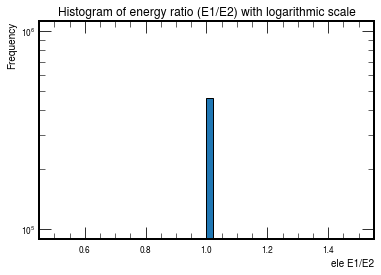

min energyratio:  1.0


'\nfig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))\n\nA,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))\n\ns = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)\na = A/s\nX, Y = np.meshgrid(xedges, yedges)\nI = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")\n\nfig.colorbar(I, ax=ax, label="density")\nax.set_xlabel("$\\eta^{mean}_{seed}$", fontsize=14)\nax.set_ylabel("ele E1/E2", fontsize=14)\nplt.title(\'Mask same electron\')\nhep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)\nplt.tight_layout()\nplt.savefig(\'plots/ele_e1-e2_eta.png\')\n'

In [11]:
energy_ratio = same_ele_events['ele_et1'] / same_ele_events['ele_et2']
energy_ratio[same_ele_events['ele_et1'] < same_ele_events['ele_et2']] = same_ele_events['ele_et2'] / same_ele_events['ele_et1']

plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('ele E1/E2')
plt.ylabel('Frequency')
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale')
plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())
'''
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio,bins=(150, 150), range=((-3,3),(0,400)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("ele E1/E2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/ele_e1-e2_eta.png')
'''

## Delta R study

In [12]:
total_events = len(grouped_deltas)

same_ele_index_events = grouped_deltas[grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']]
same_ele_index_count = len(same_ele_index_events)
percentage_same_ele_index = (same_ele_index_count / total_events) * 100

print(f"Percentage of events with the same ele_index: {percentage_same_ele_index:.2f}%")

Percentage of events with the same ele_index: 23.00%


In [13]:
eta_mean_range = (1.4, 1.6)

filtered_events = grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                 (grouped_deltas['eta_mean'] <= eta_mean_range[1]) &
                                 (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2'])]
total_events_eta_range = len(grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                             (grouped_deltas['eta_mean'] <= eta_mean_range[1])])
same_ele_eta_range_count = len(filtered_events)
percentage_same_ele_index_eta_range = (same_ele_eta_range_count / total_events_eta_range) * 100

print(f"Percentage of events with the same ele_index in the range eta {eta_mean_range}: {percentage_same_ele_index_eta_range:.2f}%")

Percentage of events with the same ele_index in the range eta (1.4, 1.6): 41.48%


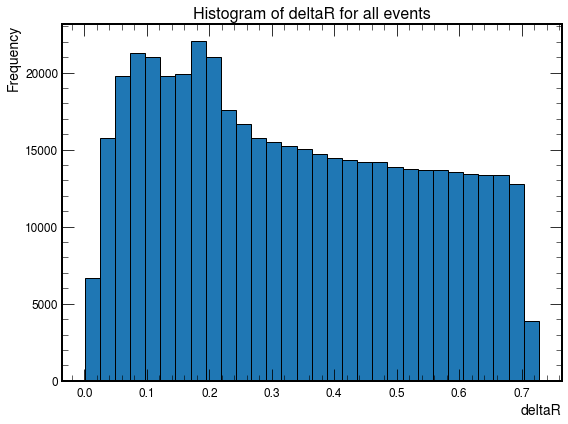

In [14]:
plt.figure(figsize=(8, 6))  
plt.hist(same_ele_events['deltaR'], bins=30, edgecolor='black')
plt.xlabel('deltaR', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.title('Histogram of deltaR for all events', fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.tight_layout() 
plt.savefig('plots/deltaR_histogram.png')
plt.show()

In [15]:
print('delta r max: ',same_ele_events['deltaR'].max())

delta r max:  0.7277818468632585


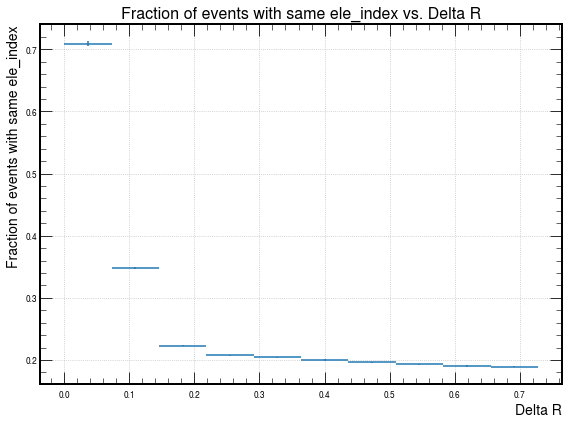

In [16]:
def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        #print('interval=[',lower_bound,upper_bound,']')
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(same_ele_events[mask])
        #print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        #print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 10
fraction_same_ele_index_vs_deltaR(num_intervals)


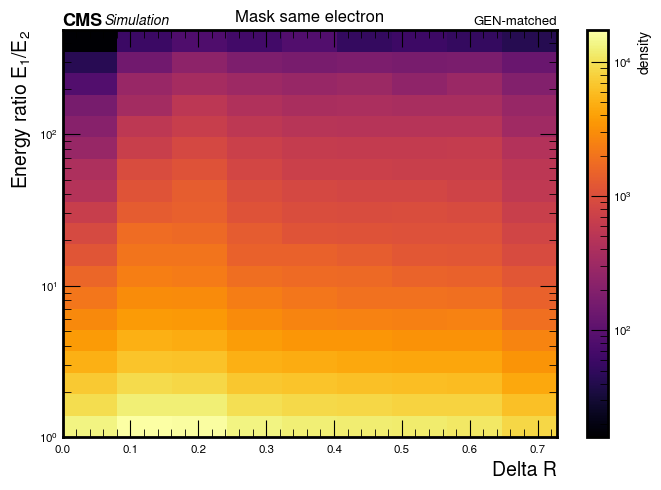

In [21]:
mask=(energy_ratio>0.8)&(energy_ratio<1.2)


fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events['deltaR'],energy_ratio,bins=[
                                      np.linspace(0,same_ele_events['deltaR'].max(),10), np.logspace(0, np.log10(energy_ratio.max()), 20, base=10)
                                  ])

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("Delta R", fontsize=14)
ax.set_ylabel("Energy ratio $E_1/E_2$", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
ax.set_yscale("log")
plt.tight_layout()
plt.savefig('plots/deltar_energyratio.png')

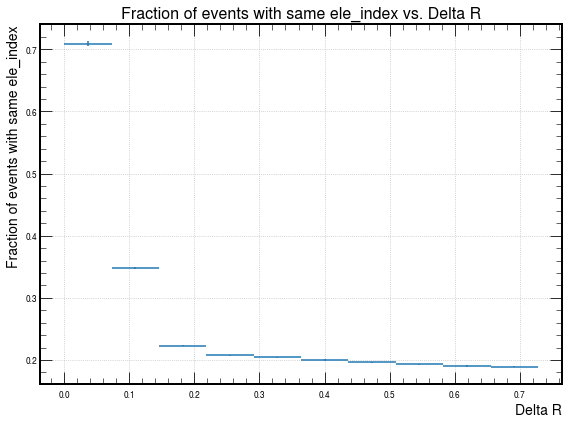

In [70]:
def nonelematched_deltar(num_intervals):
    deltaR_max = group_deltas['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)
        dr_group=grouped_deltas[mask2]
        
        
        mask = (dr_group['ele_matched1'] == False) | (dr_group['ele_matched2'] == False)
        
        
        n1 = len(dr_group[mask])
        ntot = len(dr_group)
        
        if ntot == 0:
            ntot = 1
            
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with at least one of the two ele not matched', fontsize=14) 
    #plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 10
fraction_same_ele_index_vs_deltaR(num_intervals)


In [67]:
print(False
      | False)

False


In [63]:
mask=(same_ele_events['ele_matched1']==False)&(same_ele_events['ele_matched2']==False)
print(len(same_ele_events))

459969


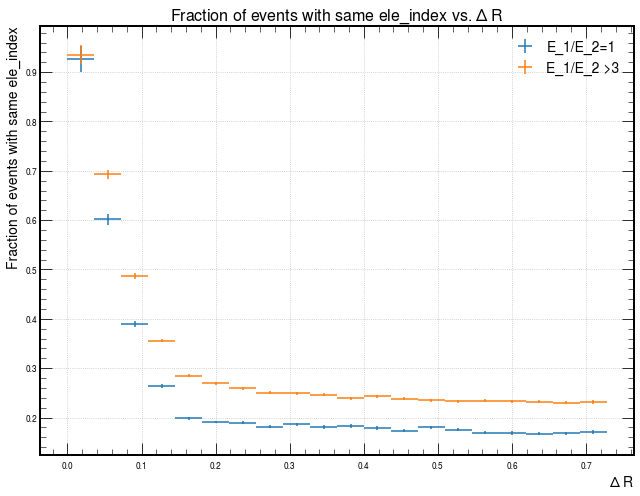

In [49]:
e_ratio_g = grouped_deltas['calo_energy1'] / grouped_deltas['calo_energy2']
e_ratio_g[grouped_deltas['calo_energy1'] < grouped_deltas['calo_energy2']] = grouped_deltas['calo_energy2'] / grouped_deltas['calo_energy1']

mask_e1_g =(e_ratio_g>0.8)&(e_ratio_g<1.2)
mask_e3_g =e_ratio_g>3
mask_e0_g =e_ratio_g<1
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3
mask_e0 =energy_ratio<1


def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)
    
    f1 = []
    f3 = []
    f0 = []
    yer1 = []
    yer3 = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1_1 = len(same_ele_events[mask&mask_e1])
        n1_3 = len(same_ele_events[mask&mask_e3])
        n1_0 = len(same_ele_events[mask&mask_e0])
        
        ntot_1 = len(grouped_deltas[mask2&mask_e1_g])
        ntot_3 = len(grouped_deltas[mask2&mask_e3_g])
        ntot_0 = len(grouped_deltas[mask2&mask_e0_g])
        if ntot_1 == 0:
            ntot_1 = 1
        if ntot_3 == 0:
            ntot_3 = 1
        if ntot_0 == 0:
            ntot_0 = 1
            
        fraction1 = n1_1 / ntot_1
        fraction3= n1_3 / ntot_3
        fraction0 = n1_0 / ntot_0
        f1.append(fraction1)
        f3.append(fraction3)
        f0.append(fraction0)
        yer1.append(np.sqrt(n1_1 + n1_1**2 / ntot_1) / ntot_1)
        yer3.append(np.sqrt(n1_3 + n1_3**2 / ntot_3) / ntot_3)

    plt.figure(figsize=(9,7))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, f1, xerr=np.ones(num_intervals) * y / 2, yerr=yer1, fmt='none', label='E_1/E_2=1')
    plt.errorbar(deltaR_values[:-1] + y / 2, f3, xerr=np.ones(num_intervals) * y / 2, yerr=yer3, fmt='none', label='E_1/E_2 >3',ecolor='#ff7f0e')
    #plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, f1, label='E_1/E_2=1')
    #plt.scatter(deltaR_values[:-1] + y / 2, f3, label='E_1/E_2 >3')
    #plt.scatter(deltaR_values[:-1] + y / 2, f0, label='E_1/E_2<1')
    plt.xlabel('$\Delta \; R$', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.legend(fontsize=14)
    plt.title('Fraction of events with same ele_index vs. $\Delta \; R$', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 20
fraction_same_ele_index_vs_deltaR(num_intervals)


## mask in respect to eta

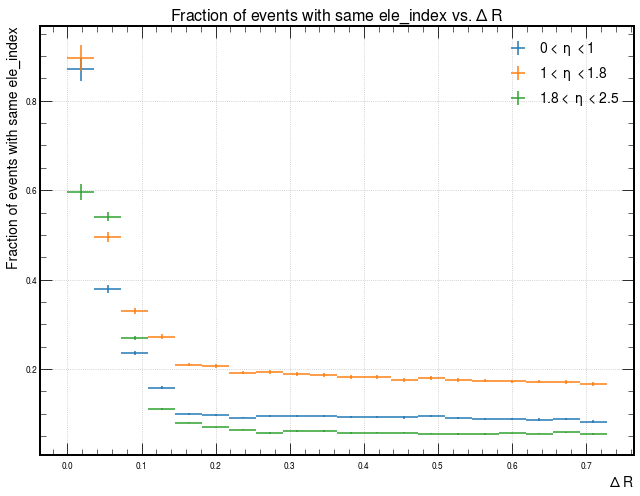

In [56]:
e_ratio_g = grouped_deltas['calo_energy1'] / grouped_deltas['calo_energy2']
e_ratio_g[grouped_deltas['calo_energy1'] < grouped_deltas['calo_energy2']] = grouped_deltas['calo_energy2'] / grouped_deltas['calo_energy1']

mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
mask_e0_g =(grouped_deltas.eta_mean<3)&(grouped_deltas.eta_mean>1.8)
mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)


def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)
    
    f1 = []
    f3 = []
    f0 = []
    yer1 = []
    yer3 = []
    yer0=[]

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1_1 = len(same_ele_events[mask&mask_e1])
        n1_3 = len(same_ele_events[mask&mask_e3])
        n1_0 = len(same_ele_events[mask&mask_e0])
        
        ntot_1 = len(grouped_deltas[mask2&mask_e1_g])
        ntot_3 = len(grouped_deltas[mask2&mask_e3_g])
        ntot_0 = len(grouped_deltas[mask2&mask_e0_g])
        if ntot_1 == 0:
            ntot_1 = 1
        if ntot_3 == 0:
            ntot_3 = 1
        if ntot_0 == 0:
            ntot_0 = 1
            
        fraction1 = n1_1 / ntot_1
        fraction3= n1_3 / ntot_3
        fraction0 = n1_0 / ntot_0
        f1.append(fraction1)
        f3.append(fraction3)
        f0.append(fraction0)
        yer1.append(np.sqrt(n1_1 + n1_1**2 / ntot_1) / ntot_1)
        yer3.append(np.sqrt(n1_3 + n1_3**2 / ntot_3) / ntot_3)
        yer0.append(np.sqrt(n1_0 + n1_0**2 / ntot_0) / ntot_0)

    plt.figure(figsize=(9,7))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, f1, xerr=np.ones(num_intervals) * y / 2, yerr=yer1, fmt='none', label='$0< \; \eta \; <1$')
    plt.errorbar(deltaR_values[:-1] + y / 2, f3, xerr=np.ones(num_intervals) * y / 2, yerr=yer3, fmt='none', label='$1< \; \eta \; <1.8$',ecolor='#ff7f0e')
    plt.errorbar(deltaR_values[:-1] + y / 2, f0, xerr=np.ones(num_intervals) * y / 2, yerr=yer0, fmt='none', label='$1.8< \; \eta \; <2.5$',ecolor='#2ca02c')
    #plt.scatter(deltaR_values[:-1] + y / 2, f1, label='E_1/E_2=1')
    #plt.scatter(deltaR_values[:-1] + y / 2, f3, label='E_1/E_2 >3')
    #plt.scatter(deltaR_values[:-1] + y / 2, f0, label='E_1/E_2<1')
    plt.xlabel('$\Delta \; R$', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.legend(fontsize=14)
    plt.title('Fraction of events with same ele_index vs. $\Delta \; R$', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 20
fraction_same_ele_index_vs_deltaR(num_intervals)
